In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from copy import deepcopy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from bokeh.plotting import output_file, output_notebook, figure, show
import os
os.chdir('/home/mfc/Dropbox/spring2016/dataMining/projects/project3/')
from sys import stderr, stdout
from CART.cart2 import *
import pickle

# dividing the data into training, validation and testing parts , 5000 each. 
## poker hand dataset (https://archive.ics.uci.edu/ml/datasets/Poker+Hand)

In [6]:
col_name = ['s1', 'c1', 's2', 'c2', 's3', 'c3', 's4', 'c4', 's5', 'c5', 'label']
df = pd.read_csv('data/poker-hand-training-true.data.txt', names=col_name)
train_data = df[:5000]
valid_data = df[5001:10000]
test_data = df[10001:15000]

# histogram. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa713a01518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa71148f1d0>]], dtype=object)

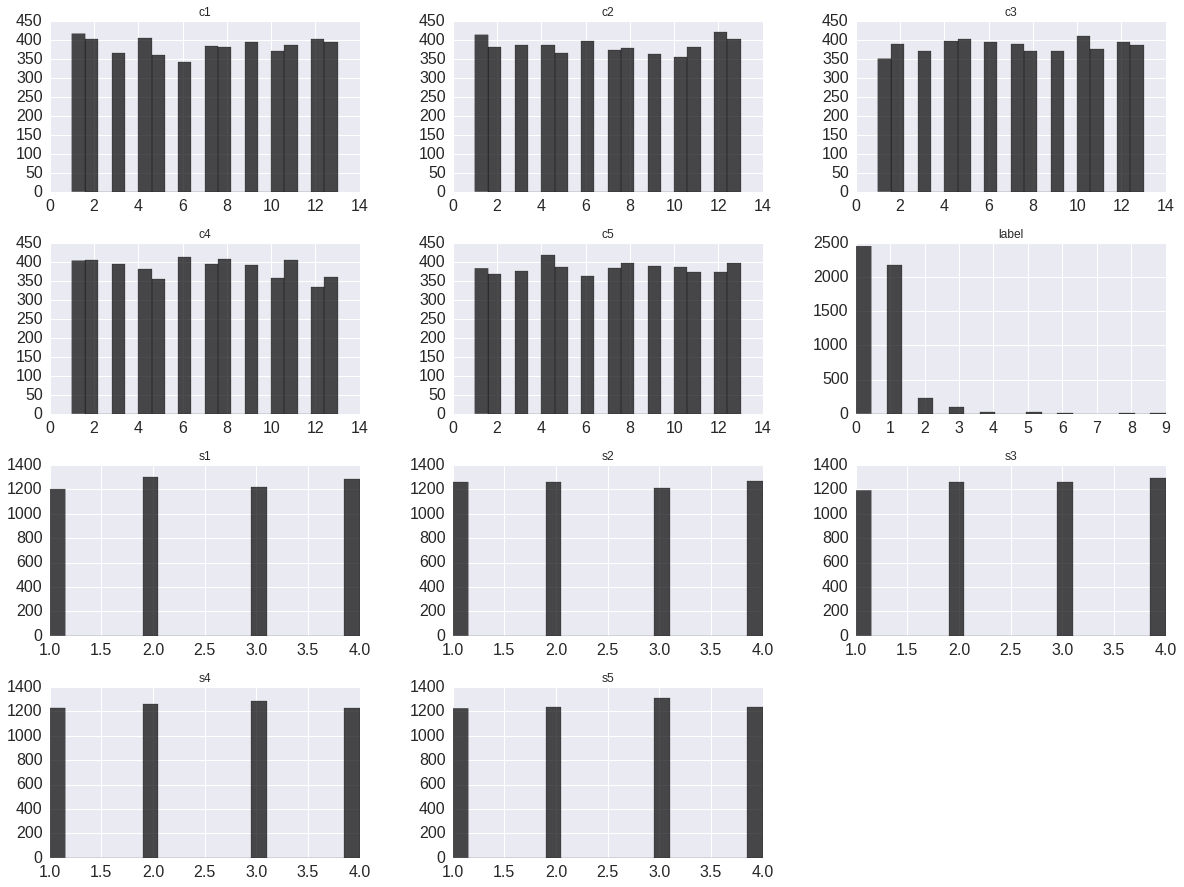

In [4]:
train_data.ix[:,:11].hist(color='k', alpha=0.7, figsize=(20,15), bins=20, xlabelsize=16, ylabelsize=16)

# growing the tree on the traning data. using entropy impurity function.

In [4]:
new = 0
if new:
    my_tree = growDecisionTreeFrom(train_data.values.tolist(), evaluationFunction=gini)
    with open('model.pkl','wb') as f:
        pickle.dump(my_tree, f)
else: 
    with open('model.pkl','rb') as f:
        my_tree = pickle.load(f)
print("finished")

finished


# drawing the tree diagram.

In [20]:
with open('original.tree.txt','w') as f:
    f.write(plot(my_tree, column_name=col_name))
try:
    drawtree(my_tree, jpeg='original.tree.jpeg', column_name=col_name)
except:
    print('Failed to save tree plot')
print("finished")

Failed to save tree plot
finished


# draw original tree. (it's too large to see the whole thing, need to zoom in)

![tree](../doc/tree.jpg)

# pruning the tree using minimum gain criteria. find the the best minimum gain value using classification error rate on validation dataset

In [7]:
mingain = np.linspace(0.01, 5, 200)

error = {}
for i in mingain:
    prediction = []
    this_tree = deepcopy(my_tree)
    try:
#         print('success')
        prune(this_tree, minGain=i, evaluationFunction=gini)
    except:
        print('mingGain:', i)
        continue
    for obs in valid_data.values.tolist():
        obs_pred = classify(obs, this_tree)
        prediction.append(max(obs_pred, key=obs_pred.get))
    comp_class = map(lambda x: x[0] == x[1], zip(prediction, valid_data.label.values.tolist()))
    error_rate = 1 - (sum(comp_class) / len(valid_data.label))
    error[i] = error_rate
print('finished')

# pruned the tree with the best value  obtained above

In [9]:
minGain = min(error, key=error.get)
this_tree = deepcopy(my_tree)
prune(this_tree, minGain=minGain, evaluationFunction=gini)

# draw the pruned tree

In [19]:
with open('pruned.tree.txt','w') as f:
    f.write(plot(this_tree, column_name=col_name))
try:
    drawtree(this_tree, jpeg='./doc/second.tree.jpeg', column_name=col_name)
except:
    print('Failed to save tree plot')

# the number on each node is (class label: number of observation in that node)
![pruned tree](../doc/second.tree.jpeg)

# classification error rate on test data set

In [31]:
for obs in test_data.values.tolist():
    obs_pred = classify(obs, this_tree)
    prediction.append(max(obs_pred, key=obs_pred.get))
    comp_class = map(lambda x: x[0] == x[1], zip(prediction, valid_data.label.values.tolist()))
    error_rate = 1 - (sum(comp_class) / len(valid_data.label))
error_rate

0.5013002600520104